In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

In [2]:
# Read it in
path = "surveys.xlsx"
survey_32W = pd.read_excel(path, sheet_name="Survey_32W", converters={'T3':str})

# Drop unnecessary columns
survey_32W.drop(columns=['Unnamed: 0', 'subject_id', 'image_name', 'image_name_2'], inplace=True)

# Drop rows missing response
survey_32W = survey_32W[
    (survey_32W['T3'] != ' ') &
    (survey_32W['T3'] != 'none') &
    (survey_32W['T3'].notnull()) &
    (survey_32W['T3'] != 'No Comments ') &
    (survey_32W['T3'] != 0) &
    (survey_32W['T3'] != 'None') &
    (survey_32W['T3'] != '[NO ANSWER]') &
    (survey_32W['T3'] != 'no comments') &
    (survey_32W['T3'] != 'no comments.') &
    (survey_32W['T3'] != '0') &
    (survey_32W['T3'] != 'none.') &
    (survey_32W['T3'] != '[none]') &
    (survey_32W['T3'] != 'no comment') &
    (survey_32W['T3'] != 'No comments were made') &
    (survey_32W['T3'] != 'No Reason') &
    (survey_32W['T3'] != 'No reason.')]

# Select responses
res_same_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be together in the same outfits']"].tolist()
res_separate_32W = survey_32W['T3'][survey_32W['T1'] == "['They should be in separate outfits']"].tolist()
res_32W = res_same_32W + res_separate_32W

In [3]:
embed_same_32W = model.encode(res_same_32W)
embed_separate_32W = model.encode(res_separate_32W)
embed_32W = np.concatenate((embed_same_32W, embed_separate_32W), axis = 0)

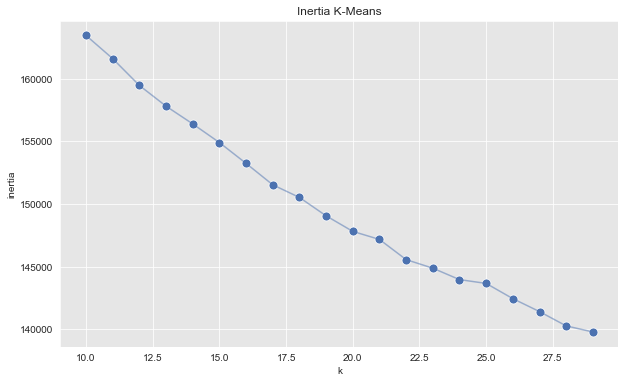

In [4]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

inertias = []

k_candidates = range(10, 30)

for k in k_candidates:
    k_means = KMeans(random_state=0, n_clusters=k)
    k_means.fit(embed_32W)
    inertias.append(k_means.inertia_)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
# sns.scatterplot(x=[k_candidates[2]], y = [inertias[2]], color=sns_c[3], s=150, ax=ax)
sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');

In [6]:
def compare_all(i, res, embed):
    distances = scipy.spatial.distance.cdist([embed], embed_32W, "cosine")[0]
    distances_sorted = sorted(zip(range(len(distances)), distances), key=lambda x: x[1])
    return {
        "index": i,
        "response": res,
        "choice": "same" if i < len(res_same_32W) else "separate",
        "match": res_32W[distances_sorted[1][0]],
        "match_choice": "same" if distances_sorted[1][0] < len(res_same_32W) else "separate",
        "score": 1-distances_sorted[1][1]
    }

results = [compare_all(i, res, embed) for i, res, embed in zip(range(len(res_32W)), res_32W, embed_32W)]

In [7]:
k = 23
kmeans = KMeans(n_clusters=k).fit(embed_32W)

# Print results
for i in range(k):
    print("Cluster", i)
    print([results[j]['response'] for j in range(len(kmeans.labels_)) if kmeans.labels_[j] == i])

Cluster 0
['I believe if they were trained with white soldiers they would [be] better soldiers.', 'because if their fighting for the same cuuse should have the same privilegs is white', 'Lessens infiror and superior complexes among the men of what is supposed to be a united people', "THEY SHOULD BE GIVEN EQUAL RIGHTS + PRIVILEGES AS WHITE SOLDIERS BUT I DON'T WANT ONE FOR A BUDDY.", "Because myself would soldier with them, don't think any more white would like", 'Be case the most af the Boy is white in the have truBle with the neogro', 'because they are not as clean as wer white people are', 'white boys [unclear][/unclear] [unclear][/unclear] [unclear][/unclear] and better [unclear][/unclear]', 'It would lower the efficiency of the white outfits', 'a separat outfits for white and colors', 'whites can get along beter between there selveswith out of color people', 'Being together Might Cause trouble between the whites and the nergoes.', 'There are too many kinds of white people, most of 

In [9]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=23, affinity='nearest_neighbors').fit(embed_32W)

# Print results
for i in range(k):
    print("Cluster", i)
    print([results[j]['response'] for j in range(len(sc.labels_)) if sc.labels_[j] == i])

Cluster 0
['Reasons essentially [insertion]the[/insertion] same as above two questions. [paragraph] the myth of colored people being inferior would be largely destroyed - Why not apply "practical education" of "actual demonstration" methods to which the army subscribes to the Negro question as well as everything else. ', "We are all in this for the cause and see no reason why they shouldn't be allowed & fight with us side by side", 'We all fight for same cause.', 'America is a groups of mixed races and the colored man will die as quick as the white in Defense of his country', 'We are one army and there for should fight as one. ', 'Whites & Negroes are fightig a war of liberation [deletion][/deletion] this fight should be done in complete unity.', 'Keep the colored race seperate from the white race', 'They fight just as hard as the white man', 'because be are brother and have as much heart as we have in our body.', 'A man is a man regardless of his color or race.', 'The people must lear

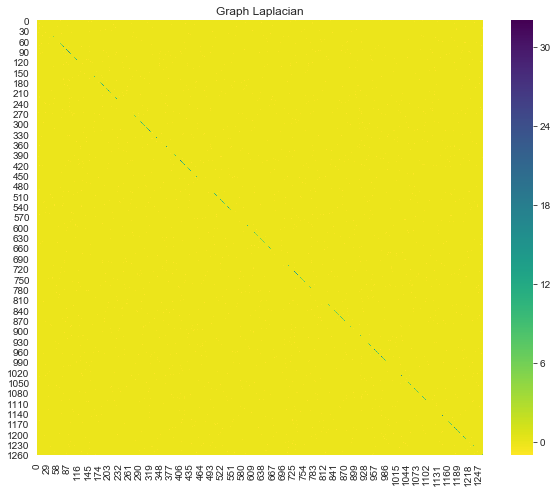

In [10]:
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=embed_32W, nn=8)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

In [11]:
from scipy import linalg

eigenvals, eigenvcts = linalg.eig(graph_laplacian)
np.unique(np.imag(eigenvals))

array([0.])

In [12]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

In [18]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=1), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 1.4142135623771632
Max Norm: 35.510561809129406


In [19]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

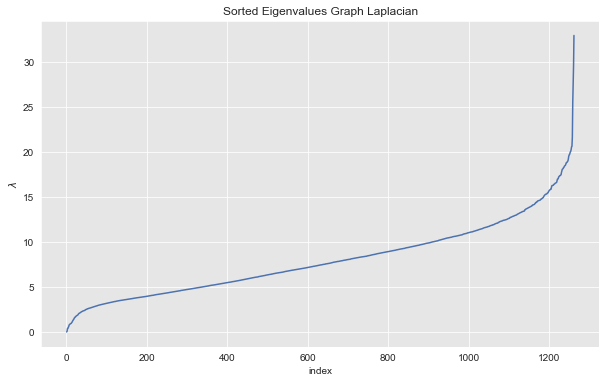

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

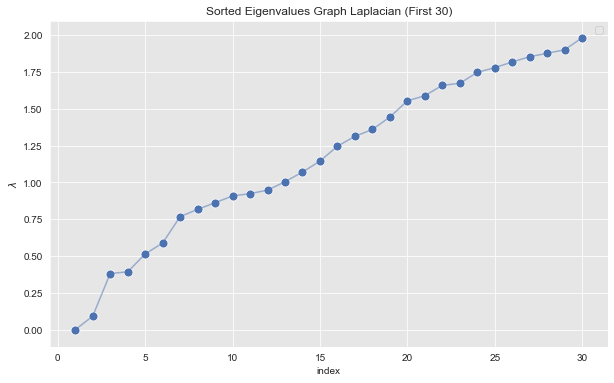

In [21]:
index_lim = 30

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
# ax.axvline(x=3, color=sns_c[3], label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');